In [2]:
import pandas as pd
import numpy as np
import folktables
from folktables import ACSDataSource
from utils import utility
from utils.encoder import OneHotEncoder, ThermometerEncoder, IntegerEncoder
from sklearn.linear_model import Ridge
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
%load_ext autoreload
%autoreload 2

In [3]:
ACSIncomeNew = folktables.BasicProblem(
    features=[
        'COW',
        'AGEP', #age
        'SCHL', #education level
        'MAR',
        'OCCP',
        'POBP',
        'WKHP', #working per hours (0<=x<=99)
        'SEX',
        'RAC1P',
        'ENG', #english level
    ],
    target='PINCP', #total person's income
    target_transform=lambda x:x,
    group=['AGEP','SCHL','WKHP','ENG'],
    preprocess=folktables.adult_filter,
    postprocess=lambda x:x,
)

In [4]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
ca_data = data_source.get_data(states=["CA"], download=True)

In [5]:
data, target, ordinal = ACSIncomeNew.df_to_pandas(ca_data)

In [6]:
if data.isnull().values.any():
    data = data.dropna()
    ordinal = ordinal.loc[data.index,:]
    target = target.loc[data.index,:]

In [7]:
nominal_features = ['COW', 'MAR', 'SEX', 'RAC1P']
ordinal_features = ['AGEP', 'SCHL', 'WKHP', 'ENG'] #ordinal.columns
label = ['PINCP'] #target.columns
other_features = list(set(data.columns) - (set(nominal_features + ordinal_features)))

ordinal_features_plus = ordinal_features[:2]

In [8]:
unique_dic = utility.df_to_dict(data)

unique_ordered_dic = utility.order(unique_dic, *(nominal_features+ordinal_features))

nominal_dic = {k: unique_ordered_dic[k] for k in set(unique_ordered_dic).intersection(nominal_features)}
ordinal_dic = {k: unique_ordered_dic[k] for k in set(unique_ordered_dic).intersection(ordinal_features)}


ordinal_dic_plus = {key: ordinal_dic[key] for key in ordinal_features_plus}

In [9]:
step_sizes = {'AGEP': (0, 99, 10), 'WKHP': (1, 99, 10)}

In [10]:
ordinal_dic_intv = ordinal_dic.copy()
for key, val in step_sizes.items():
    ordinal_dic_intv[key] = np.arange(*val)
other_num, nom_num, ord_num = len(other_features), sum([len(val) for val in nominal_dic.values()]), sum([len(val) for val in ordinal_dic_intv.values()])
other_num + nom_num + ord_num, other_num + nom_num + len(ordinal_dic)

(74, 30)

In [11]:
df=pd.concat([data, target],axis=1)
df.to_csv('clean_dataset/acs_datasource/acs_datasource.csv', index=False)

In [12]:
df=pd.concat([data, target],axis=1)
df.to_csv('clean_dataset/acs_datasource/acs_datasource.csv')
feature_dic = {'nominal': nominal_dic, 'ordinal': ordinal_dic_intv, 'step_sizes': step_sizes, 'label':label}
import pickle
with open('clean_dataset/acs_datasource/acs_datasource_dic.pkl', 'wb') as f:
    pickle.dump(feature_dic, f)

In [12]:
import pickle
with open('clean_dataset/acs_datasource/acs_datasource_dic.pkl', 'rb') as f:
    dic = pickle.load(f)
dic

{'nominal': {'SEX': array([1., 2.]),
  'RAC1P': array([1., 2., 3., 4., 5., 6., 7., 8., 9.]),
  'MAR': array([1., 2., 3., 4., 5.]),
  'COW': array([1., 2., 3., 4., 5., 6., 7., 8.])},
 'ordinal': {'WKHP': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
  'AGEP': array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]),
  'SCHL': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
         14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.]),
  'ENG': array([1., 2., 3., 4.])},
 'step_sizes': {'AGEP': (0, 99, 10), 'WKHP': (1, 99, 10)}}

In [13]:
# import random
# from sklearn.model_selection import KFold
# df = pd.concat([data, target],axis=1)
# k=10
# test_size = 0.25
# regr = Ridge()
# test_pred_res, test_true_res = [], []
# train_pred_res, train_true_res = [], []
# sc = StandardScaler()
# kf = KFold(k)   
# X = df.iloc[:, :-1]
# y = df.iloc[:, -1]
# random.seed(0)
# for train_index, test_index in kf.split(df):
#     X_train, y_train, X_test, y_test = X.iloc[train_index], pd.DataFrame(y.iloc[train_index]), X.iloc[test_index], pd.DataFrame(y.iloc[test_index])
#     # random_train, random_test, _ = utility.encoding_pipeline(X_train[ordinal_features_plus], X_test[ordinal_features_plus], ThermometerEncoder, ordinal_dic_plus)
#     nominal_train, nominal_test, _ = utility.encoding_pipeline(X_train[nominal_features], X_test[nominal_features], OneHotEncoder, nominal_dic)
#     ordinal_train, ordinal_test, _ = utility.encoding_pipeline(X_train[ordinal_features], X_test[ordinal_features], ThermometerEncoder, ordinal_dic, step_sizes=step_sizes)
#     other_train, other_test = np.array(X_train[other_features].values), np.array(X_test[other_features].values)
#     sc.fit(other_train)
#     other_train, other_test = sc.transform(other_train), sc.transform(other_test)
#     sc.fit(y_train)
#     y_train, y_test = sc.transform(y_train), sc.transform(y_test)
#     # X_train_all, X_test_all = ordinal_train, ordinal_test
#     X_train_all, X_test_all = np.concatenate([other_train, nominal_train, ordinal_train], axis=1), np.concatenate([other_test, nominal_test, ordinal_test], axis=1)
#     # X_train_all, X_test_all = np.concatenate([other_train, nominal_train, ordinal_train, random_train], axis=1), np.concatenate([other_test, nominal_test, ordinal_test, random_test], axis=1)
#     regr.fit(X_train_all, y_train)
#     y_pred_test = regr.predict(X_test_all)
#     y_pred_train = regr.predict(X_train_all)
#     test_true_res = test_true_res+ [np.squeeze(y_test)] if len(test_true_res)> 0 else [np.squeeze(y_test)]
#     test_pred_res = test_pred_res+ [np.squeeze(y_pred_test)] if len(test_pred_res)> 0 else [np.squeeze(y_pred_test)]
#     train_true_res = train_true_res+ [np.squeeze(y_train)] if len(train_true_res)> 0 else [np.squeeze(y_train)]
#     train_pred_res = train_pred_res+ [np.squeeze(y_pred_train)] if len(train_pred_res)> 0 else [np.squeeze(y_pred_train)]

# test_temp_res, train_temp_res = [], []
# for i in range(k):
#     test_temp_res.append(mean_squared_error(test_true_res[i], (test_pred_res[i]), squared=False)) 
#     train_temp_res.append(mean_squared_error(train_true_res[i], (train_pred_res[i]), squared=False)) 
# test_res, train_res = (np.mean(test_temp_res), np.std(test_temp_res)), (np.mean(train_temp_res), np.std(train_temp_res))

In [14]:
# train_res, test_res

In [15]:
res, models, res_train = utility.k_fold_validation(k=10, 
                  df=pd.concat([data, target],axis=1), 
                  encoders=[OneHotEncoder, ThermometerEncoder, IntegerEncoder], 
                  step_sizes=step_sizes,
                  pred_task=
                    {
                      'name': 'regression',
                      'model': Ridge(),
                      'metric': {
                            'RMSE': lambda x,y : mean_squared_error(x, y, squared=False), 
                            'MAE': mean_absolute_error
                            }
                    }, 
                  features=
                    {
                      'ordinal': {
                        'name': ordinal_features,
                        'dict': ordinal_dic
                      },
                      'nominal': {
                        'name': nominal_features,
                        'dict': nominal_dic
                      },
                      'numerical': other_features,
                    },
                    return_model=True,
                    train_result=True)

c:\Users\wmarc\anaconda3\envs\bthesis\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\wmarc\anaconda3\envs\bthesis\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\wmarc\anaconda3\envs\bthesis\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\wmarc\anaconda3\envs\bthesis\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Ch

In [16]:
res

{'OneHotEncoder': {'RMSE': (0.8244125936618627, 0.0450669378740063),
  'MAE': (0.4285137874631806, 0.012301663883468757)},
 'ThermometerEncoder': {'RMSE': (0.8244121164907119, 0.04506432628017148),
  'MAE': (0.42851894705308197, 0.012302759718789536)},
 'IntegerEncoder': {'RMSE': (0.8590320123836171, 0.04638498526955386),
  'MAE': (0.46222411682513764, 0.011234780738151413)}}

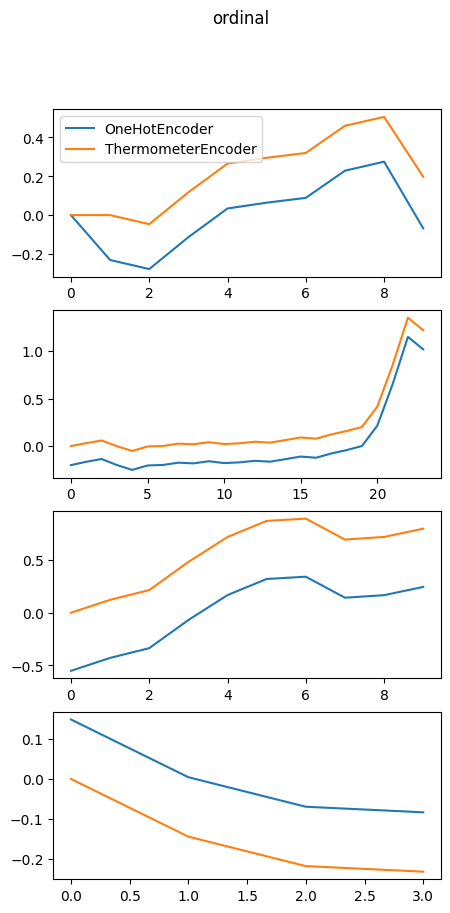

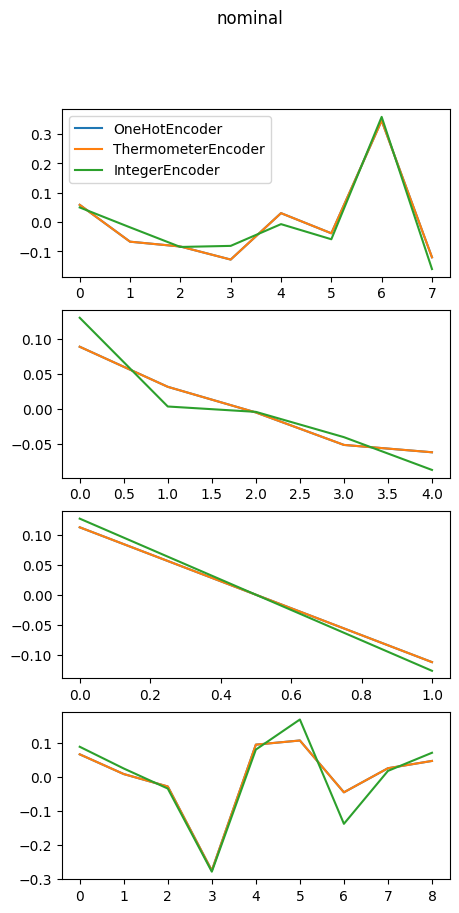

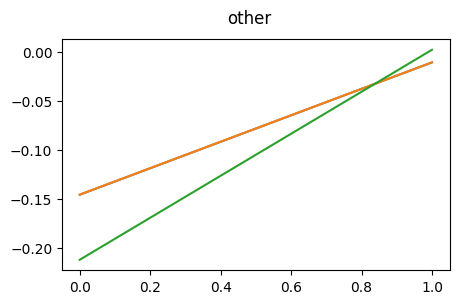

In [17]:
ohe_1 = models['OneHotEncoder'][9]
te_1 = models['ThermometerEncoder'][9]
ie_1 = models['IntegerEncoder'][9]



ordinal_dic_intv = ordinal_dic.copy()
for key, val in step_sizes.items():
    ordinal_dic_intv[key] = np.arange(*val)
    
    
other_num, nom_num, ord_num = len(other_features), sum([len(val) for val in nominal_dic.values()]), sum([len(val) for val in ordinal_dic.values()])
nom_coef_dic = utility.create_coef_dic(other_num, nominal_dic, nominal_features, ohe_1.coef_,te_1.coef_, ie_1.coef_)
ord_coef_dic = utility.create_coef_dic(other_num+nom_num, ordinal_dic_intv, ordinal_features, ohe_1.coef_,te_1.coef_)
ord_coef_dic_cum = {key: [val[0]]+[np.cumsum(val[1])] for key, val in ord_coef_dic.items()}

import matplotlib.pyplot as plt

label=['OneHotEncoder', 'ThermometerEncoder', 'IntegerEncoder']

fig, ax = plt.subplots(len(ord_coef_dic.keys()), 1, figsize=(5,10))
fig.suptitle('ordinal')
for i, (key, val) in enumerate(ord_coef_dic_cum.items()):
    for j in range(len(val)):
        ax[i].plot(range(len(val[j])), val[j], label = label[j])
ax[0].legend()    

fig, ax = plt.subplots(len(nom_coef_dic.keys()), 1, figsize=(5,10))
fig.suptitle('nominal')
for i, (key, val) in enumerate(nom_coef_dic.items()):
    for j in range(len(val)):
        ax[i].plot(range(len(val[j])), val[j], label = label[j])
ax[0].legend()  

fig = plt.figure(figsize=(5,3))
fig.suptitle('other')
plt.plot(range(len(ohe_1.coef_[0][:other_num])), ohe_1.coef_[0][:other_num])
plt.plot(range(len(te_1.coef_[0][:other_num])), te_1.coef_[0][:other_num])
plt.plot(range(len(ie_1.coef_[0][:other_num])), ie_1.coef_[0][:other_num])

In [18]:
k=10
ordinal_dic_intv = ordinal_dic.copy()
for key, val in step_sizes.items():
    ordinal_dic_intv[key] = np.arange(*val)
    
spec_dic = {key: [] for key in ordinal_dic_intv.keys()}
for i in range(k):
    ohe_1 = models['OneHotEncoder'][i]
    te_1 = models['ThermometerEncoder'][i]
    ie_1 = models['IntegerEncoder'][i]

    other_num, nom_num, ord_num = len(other_features), sum([len(val) for val in nominal_dic.values()]), sum([len(val) for val in ordinal_dic_intv.values()])

    ord_coef_dic = utility.create_coef_dic(other_num+nom_num, ordinal_dic_intv, ordinal_features, ohe_1.coef_,te_1.coef_)
    ord_coef_dic_cum = {key: [val[0]]+[np.cumsum(val[1])] for key, val in ord_coef_dic.items()}
    for key, val in ord_coef_dic_cum.items():
        spec_dic[key] += [np.corrcoef(val)[0][1]]
spec_dic_mean_std = {key : (np.mean(val), np.std(val)) for key, val in spec_dic.items()}

In [19]:
spec_dic_mean_std

{'WKHP': (0.9999988359479376, 3.0057467011997306e-07),
 'AGEP': (0.9198176076673363, 0.006556112178890928),
 'SCHL': (0.9999917341108701, 1.1256925755360153e-06),
 'ENG': (0.9999999257770533, 1.18309494189934e-08)}

Text(0, 0.5, 'correlation')

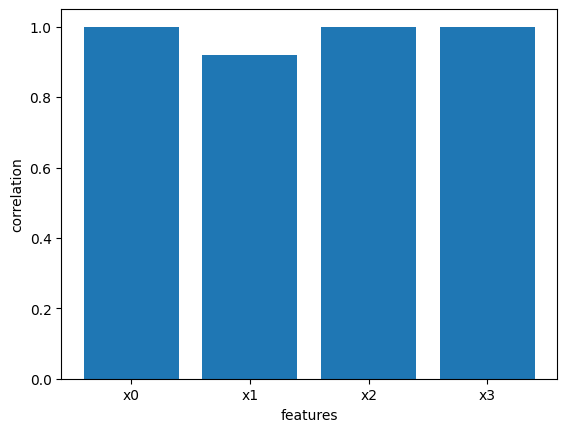

In [20]:
spec_plot = {key: val[0] for key, val in spec_dic_mean_std.items()}
plt.bar([f'x{i}' for i in range(len(spec_plot))], spec_plot.values())
plt.xlabel('features')
plt.ylabel('correlation')

In [17]:
other_num, nom_num, ord_num = len(other_features), sum([len(val) for val in nominal_dic.values()]), sum([len(val) for val in ordinal_dic.values()])

all_ohe_coef = np.array([models['OneHotEncoder'][i].coef_ for i in range(k)]).squeeze()
all_te_coef = np.array([models['ThermometerEncoder'][i].coef_ for i in range(k)]).squeeze()
# all_te_coef_cumsum = [np.cumsum(all_te_coef[:, other_num+nom_num:], axis=1) for i in [len(val) for val in ordinal_dic.values()]]
all_te_coef_cumsum = []
s=0
for i in [len(val) for val in ordinal_dic_intv.values()]:
    all_te_coef_cumsum.append(np.cumsum(all_te_coef[:, other_num+nom_num+s:other_num+nom_num+s+i], axis=1))
    s+=i
all_te_coef_cumsum = np.concatenate(tuple(all_te_coef_cumsum), axis=1)
all_ie_coef = np.array([models['IntegerEncoder'][i].coef_ for i in range(k)]).squeeze()


all_ohe_coef_mean = np.mean(all_ohe_coef, axis=0)
# all_te_coef_mean = np.array(list(np.mean(all_te_coef, axis=0)[:other_num+nom_num]) + list(np.mean(all_te_coef_cumsum, axis=0)))
all_te_coef_mean = np.mean(np.concatenate((all_te_coef[:, :other_num+nom_num], all_te_coef_cumsum), axis=1), axis=0)
all_ie_coef_mean = np.mean(all_ie_coef, axis=0)
all_ie_coef_temp = []
for idx, i in enumerate([len(val) for val in ordinal_dic_intv.values()]):
    all_ie_coef_temp.append(np.array([all_ie_coef_mean[other_num+nom_num:][idx]]*i)*np.linspace(1,i,i))
all_ie_coef_temp = np.concatenate(tuple(all_ie_coef_temp))
all_ie_coef_mean = np.concatenate((all_ie_coef_mean[:other_num+nom_num], all_ie_coef_temp))

# all_ohe_coef_mean = StandardScaler().fit_transform(all_ohe_coef_mean.reshape(-1, 1)).squeeze()
# all_te_coef_mean = StandardScaler().fit_transform(all_te_coef_mean.reshape(-1, 1)).squeeze()
# all_ie_coef_mean = StandardScaler().fit_transform(all_ie_coef_mean.reshape(-1, 1)).squeeze()

all_ohe_coef_std = np.std(all_ohe_coef, axis=0)
all_te_coef_std = np.array(list(np.std(all_te_coef, axis=0)[:other_num+nom_num]) + list(np.std(all_te_coef_cumsum, axis=0)))
all_ie_coef_std = np.std(all_ie_coef, axis=0)
all_ie_coef_temp = []
for idx, i in enumerate([len(val) for val in ordinal_dic_intv.values()]):
    all_ie_coef_temp.append(np.array([all_ie_coef_std[other_num+nom_num:][idx]]*i)*np.array([1]*i))
all_ie_coef_temp = np.concatenate(tuple(all_ie_coef_temp))
all_ie_coef_std = np.concatenate((all_ie_coef_std[:other_num+nom_num], all_ie_coef_temp))

# all_ohe_coef.shape, all_te_coef.shape, all_ie_coef.shape
all_ohe_coef_mean.shape, all_te_coef_mean.shape, all_ie_coef_mean.shape
# all_ohe_coef_std.shape, all_te_coef_std.shape, all_ie_coef_std.shape

((74,), (74,), (74,))

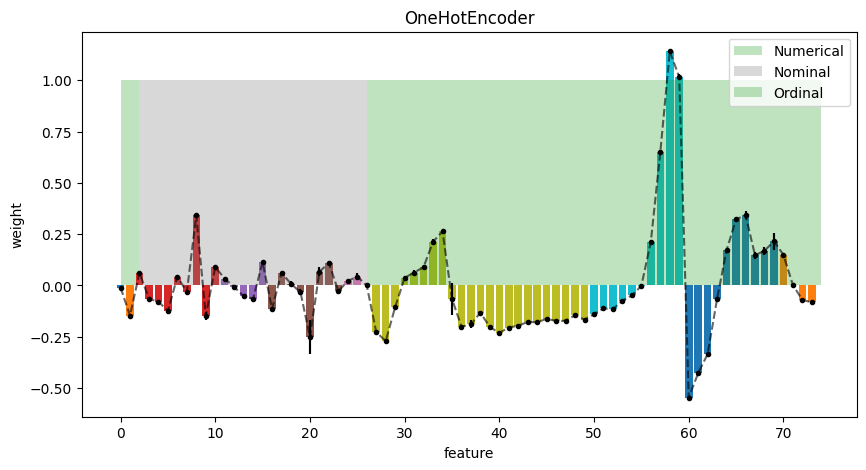

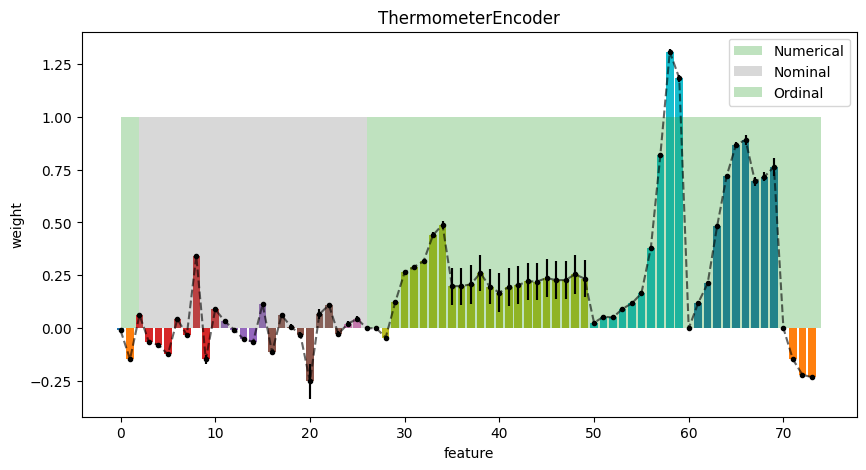

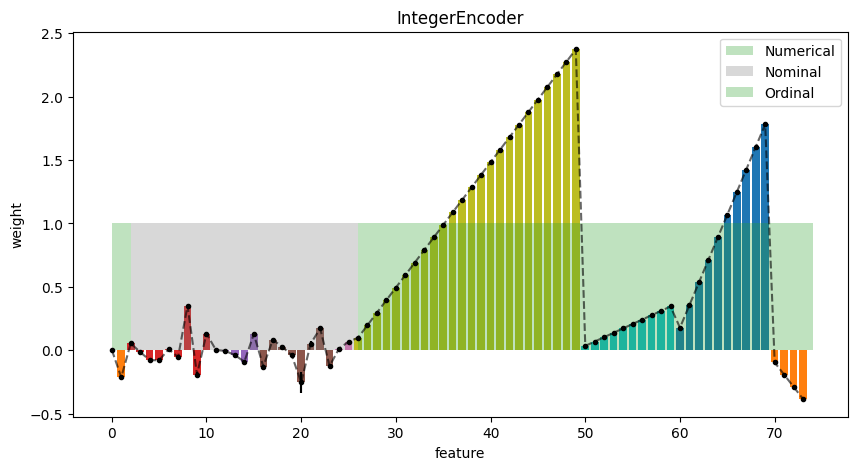

In [18]:
import matplotlib.pyplot as plt
other_num, nom_num, ord_num = len(other_features), sum([len(val) for val in nominal_dic.values()]), sum([len(val) for val in ordinal_dic_intv.values()])
title = ["OneHotEncoder", "ThermometerEncoder", "IntegerEncoder"]
label = ['Numerical', 'Nominal', 'Ordinal']
for idx, (all_mean, all_std) in enumerate(zip([all_ohe_coef_mean, all_te_coef_mean, all_ie_coef_mean], [all_ohe_coef_std, all_te_coef_std, all_ie_coef_std])):
    plt.figure(figsize=(10,5))
    start_1 = 0
    # if idx == 2:
    #     ord_num = len(ordinal_dic.values())
    for idxx, (i, unique_val) in enumerate(zip([other_num, nom_num, ord_num], [[1]*other_num, [len(val) for val in nominal_dic.values()], [len(val) for val in ordinal_dic_intv.values()]])):
        start_2 = 0
        # if idxx == 2 and idx == 2:
        #     unique_val = [1]*i
        for j in unique_val:  
            plt.bar(range(len(all_mean))[start_1+start_2:start_1+start_2+i+j], all_mean[start_1+start_2:start_1+start_2+i+j])
            start_2 += j
        plt.fill_between(x=[start_1, start_1+i] ,y1=[0.0], y2=[1,1],alpha=0.3,label=label[idxx])
        start_1 += i
        
    plt.errorbar(range(len(all_mean)), all_mean, all_std, color='black', fmt='.')
    plt.errorbar(range(len(all_mean)), all_mean, all_std, color='black', fmt='--', alpha=0.6)
    plt.title(title[idx])
    plt.ylabel('weight'), plt.xlabel('feature')
    plt.legend()


ValueError: x and y must have same first dimension, but have shapes (94,) and (24,)

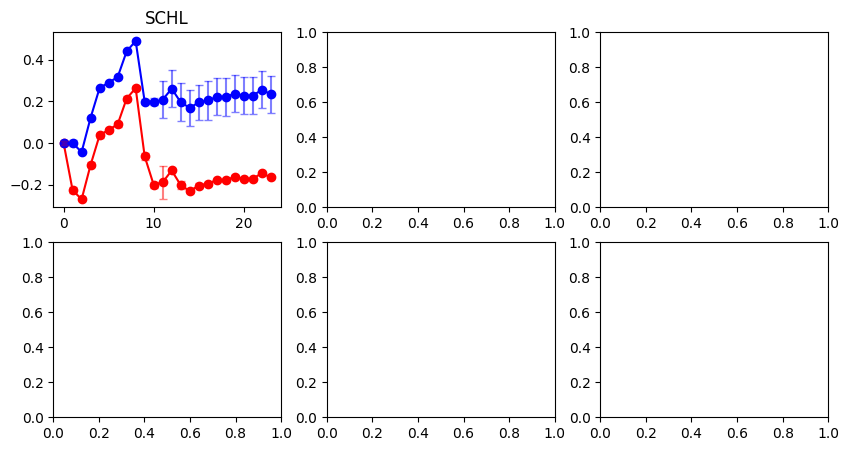

In [19]:
import matplotlib.pyplot as plt
import math
label=['OneHotEncoder', 'ThermometerEncoder']
color = ['r', 'b']
keys = list(ordinal_dic.keys())
fig, ax = plt.subplots(2, 3, figsize=(10,5))
ax = ax.ravel()
nom_num = sum([len(val) for val in nominal_dic.values()])
ord_num_list = [len(val) for val in ordinal_dic.values()]
# fig.suptitle('ordinal')
start = 0
for i, axe in enumerate(ax):
    cur_len = ord_num_list[i] 
    cur_list = range(cur_len)
    axe.plot(cur_list, all_ohe_coef_mean[other_num+nom_num+start: other_num+nom_num+start+cur_len], label = label[0], color=color[0], marker='o')
    axe.plot(cur_list, all_te_coef_mean[other_num+nom_num+start: other_num+nom_num+start+cur_len], label = label[1], color=color[1], marker='o')
    (_,caps1,_) = axe.errorbar(cur_list, all_ohe_coef_mean[other_num+nom_num+start: other_num+nom_num+start+cur_len], all_ohe_coef_std[nom_num+start: nom_num+start+cur_len],alpha = 0.5,color=color[0], fmt='.', capsize = 3)
    (_,caps2,_) = axe.errorbar(cur_list, all_te_coef_mean[other_num+nom_num+start: other_num+nom_num+start+cur_len], all_te_coef_std[nom_num+start: nom_num+start+cur_len],alpha = 0.5, color=color[1], fmt='.', capsize = 3)
    for cap in caps1+caps2:
        cap.set_markeredgewidth(1)
    axe.set_title(keys[i])
    start += cur_len
ax[0].legend()     
plt.tight_layout()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


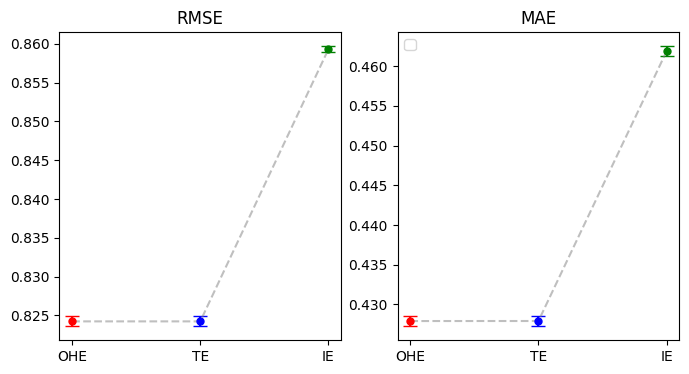

In [17]:
import matplotlib.pyplot as plt

res_temp = res_train

metrics = ['RMSE', 'MAE']
            
            
models = ["OneHotEncoder", "ThermometerEncoder", "IntegerEncoder"]
model_names = ['OHE', 'TE', 'IE']
colors = ['r', 'b', 'g']
fig, ax = plt.subplots(1, 2, figsize=(8,4))
ax = ax.ravel()
for i, metric in enumerate(metrics):
            mean, std = [], []
            for model in models:
                mean.append(res_temp[model][metric][0]), std.append(res_temp[model][metric][1])
            ax[i].errorbar(range(len(models)), mean, std, alpha = 0.5, fmt='--', color = 'grey')    
            for j, model in enumerate(models):
                (_,caps,_)= ax[i].errorbar(j, mean[j], std[j], color = colors[j], alpha = 1, fmt='.', markersize=10, capsize = 5)
                for cap in caps:
                    cap.set_markeredgewidth(1)
for i, axe in enumerate(ax):
    axe.set_title(metrics[i])
    axe.set_xticks(range(len(models)), model_names)
ax[1].legend()       

In [78]:
pd.DataFrame(res).to_csv('acs_datasource_result/acs_datasource_cv.csv')